# Base séquentielle des parcours de soins patients

Ce notebook a pour objectif de déterminer les flux de patients, c'est-à-dire visualiser les proportions de GHM et DP selon les hospitalisations successives.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
%%capture capt
p_soins=pd.read_csv("./data/parcours_soins.csv")

In [3]:
p_soins

,BEN_NIR_IDT,2008-01-15,2008-02-15,2008-03-15,2008-04-15,2008-05-15,2008-06-15,2008-07-15,2008-08-15,2008-09-15,...,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29
0,P0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10046,P24302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10047,P24303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10048,P24304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10049,P24308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Création de la base séquentielle d'hospitalisations

### Pour l'ensemble de la population

In [4]:
p_soins_list=[]
for patient in tqdm(range(len(p_soins))):
    p_soins_list.append(p_soins.iloc[patient].dropna().tolist()[1:-1])

100%|██████████| 10051/10051 [00:03<00:00, 2688.43it/s]


Dans la base séquentielle ci-dessous, les différentes colonnes correspondent aux hospitalisations successives. Ainsi, on trouve dans la 1ère colonne le GHM de la 1ère hospitalisation, pour chacun des patients suivis.

In [5]:
p_soins_df=pd.DataFrame(p_soins_list)
p_soins_df.head()

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,05K051,05M042,05M16T,05M09T,05M092,05C191,05M20Z,05M20Z,None,None,...,None,None,None,None,None,None,None,None,None,None
1,02C05J,02C05J,05M093,04M132,05C222,23M103,04M053,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,11M041,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,05M04T,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,08C11V,23M15Z,05K102,05M08T,05K102,05C191,23M101,05K191,None,None,...,None,None,None,None,None,None,None,None,None,None


Text(0, 0.5, 'Probabilité')

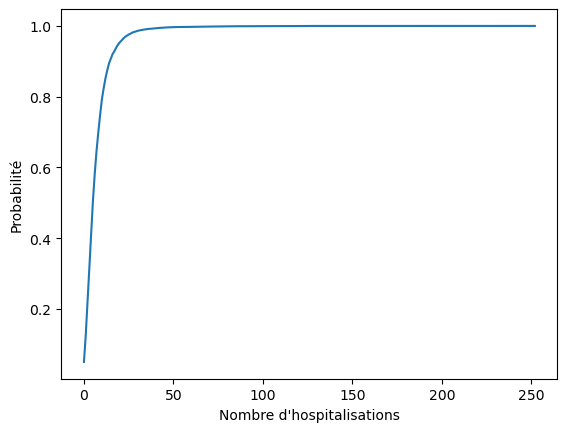

In [6]:
#CdF du nombre d'hospitalisations
(1-p_soins_df.describe().iloc[0]/len(p_soins_list)).plot()
#plt.axhline(y = 0.5, color='r', linestyle='-', label="0.5")
#plt.axhline(y = 0.05, color='r', linestyle='--', label="0.05")
#plt.axhline(y = 0.95, color='r', linestyle='-.', label="0.95")
plt.xlabel("Nombre d'hospitalisations")
plt.ylabel("Probabilité")
#plt.legend()

### Pour les patients avec une hospitalisation pour un GHM '05M091', en considérant cette hospitalisation comme début de parcours 

In [7]:
p_soins_IC=[]
for patient in tqdm(range(len(p_soins))):
    parcours=p_soins.iloc[patient].dropna()
    if parcours.eq('05M091').any():
        start=0
        while parcours.tolist()[start]!='05M091':
            start+=1
        p_soins_IC.append(parcours.tolist()[start:-1])

100%|██████████| 10051/10051 [00:06<00:00, 1634.92it/s]


In [8]:
p_soins_IC_df=pd.DataFrame(p_soins_IC)
p_soins_IC_df.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,05M091,05M171,05M13T,05M13T,05M13T,05K061,05M13T,05M13T,05M13T,05K241,...,None,None,None,None,None,None,None,None,None,None
1,05M091,23K02Z,09C081,09C082,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,05M091,05K111,05M15T,19M062,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,05M091,05M092,05M092,05M093,05M092,05M093,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,05M091,05M09T,05M093,05M093,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [9]:
p_soins_IC_df[1].describe()

count        786
unique       259
top       05M092
freq          66
Name: 1, dtype: object

Text(0, 0.5, 'Probabilité')

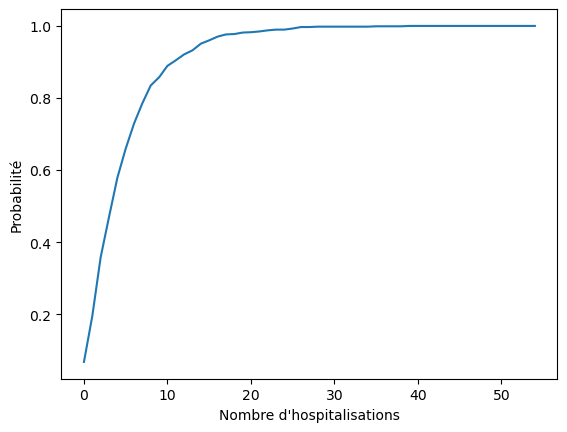

In [10]:
#CdF du nombre d'hospitalisations
(1-p_soins_IC_df.describe().iloc[0]/len(p_soins_IC)).plot()
#plt.axhline(y = 0.5, color='r', linestyle='-', label="0.5")
#plt.axhline(y = 0.05, color='r', linestyle='--', label="0.05")
#plt.axhline(y = 0.95, color='r', linestyle='-.', label="0.95")
plt.xlabel("Nombre d'hospitalisations")
plt.ylabel("Probabilité")
#plt.legend()

## Flux de patients

In [45]:
# On retire les entrées n'ayant aucune hospitalisation
p_soins_IC_df = p_soins_IC_df.dropna(thresh=1).reset_index(drop=True)

In [46]:
p_soins_IC_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
count,910,786,627,518,412,333,265,210,162,140,...,1,1,1,1,1,1,1,1,1,1
unique,1,259,280,253,211,185,157,126,115,105,...,1,1,1,1,1,1,1,1,1,1
top,05M091,05M092,05M092,05M092,05M092,05M092,05M092,05M093,05M092,05M092,...,05K15J,05M191,05K15J,21M151,05K15J,05K101,05K15J,05K15J,05K15J,05K15J
freq,910,66,58,37,31,22,26,14,15,12,...,1,1,1,1,1,1,1,1,1,1


In [270]:
def compute_prop(df, nb_hospit):
    dico={}
    dico["other"]=[]
    length=len(df)
    for n in range(nb_hospit):
        count=df[n].value_counts()
        prop=count/length
        troncated_output=prop[:5]
        for i in range(len(troncated_output.index)):
            if troncated_output.index[i] not in list(dico.keys()):
                print(list(dico.keys()))
                dico[troncated_output.index[i]]=[]
            dico[troncated_output.index[i]].append([n, troncated_output.values[i]])
        pct_na=df[n].isna().sum()/length
        dico["other"].append([n, 1-sum(troncated_output)-pct_na])
    return dico

prop=compute_prop(p_soins_IC_df, 5)

['other']
['other', '05M091']
['other', '05M091', '05M092']
['other', '05M091', '05M092', '05K101']
['other', '05M091', '05M092', '05K101', '05M093']
['other', '05M091', '05M092', '05K101', '05M093', '05M09T']
['other', '05M091', '05M092', '05K101', '05M093', '05M09T', '23M20Z']
['other', '05M091', '05M092', '05K101', '05M093', '05M09T', '23M20Z', '02C05J']


In [320]:
p_soins_IC_df[1].value_counts().sort_values(ascending=False)[:5]/len(p_soins_IC_df)

05M092    0.072527
05K101    0.058242
05M091    0.057143
05M093    0.029670
05M09T    0.024176
Name: 1, dtype: float64

In [396]:
n=10
nb_hospit=10
liste_df=[]
for n in range(nb_hospit):
    liste_df.append(pd.DataFrame(p_soins_IC_df[n].value_counts().sort_values(ascending=False)[:5]/len(p_soins_IC_df)))
df=pd.concat(L, axis=1)

In [397]:
df

,0,1,2,3,4,5,6,7,8,9
05M091,1.0,0.057143,0.034066,0.028571,0.019780,0.016484,0.009890,0.009890,0.006593,NaN
0,0.0,0.621978,0.527473,0.441758,0.357143,0.285714,0.220879,0.174725,0.135165,0.118681
05M092,NaN,0.072527,0.063736,0.040659,0.034066,0.024176,0.028571,0.015385,0.016484,0.013187
05K101,NaN,0.058242,NaN,NaN,NaN,NaN,NaN,0.007692,NaN,0.003297
05M093,NaN,0.029670,0.035165,0.023077,0.019780,0.021978,0.015385,0.015385,0.005495,0.010989
05M09T,NaN,0.024176,0.016484,0.016484,NaN,NaN,0.009890,NaN,NaN,NaN
23M20Z,NaN,NaN,0.012088,NaN,NaN,0.007692,NaN,NaN,0.008791,NaN
02C05J,NaN,NaN,NaN,0.018681,0.010989,0.009890,0.006593,0.007692,NaN,NaN
23M20T,NaN,NaN,NaN,NaN,0.010989,NaN,NaN,NaN,0.005495,NaN
04M052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004396


In [398]:
df=df.rename(index={0: "autre"})
df=df.transpose()

In [399]:
df

,05M091,autre,05M092,05K101,05M093,05M09T,23M20Z,02C05J,23M20T,04M052,16M113
0,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.057143,0.621978,0.072527,0.058242,0.029670,0.024176,NaN,NaN,NaN,NaN,NaN
2,0.034066,0.527473,0.063736,NaN,0.035165,0.016484,0.012088,NaN,NaN,NaN,NaN
3,0.028571,0.441758,0.040659,NaN,0.023077,0.016484,NaN,0.018681,NaN,NaN,NaN
4,0.019780,0.357143,0.034066,NaN,0.019780,NaN,NaN,0.010989,0.010989,NaN,NaN
5,0.016484,0.285714,0.024176,NaN,0.021978,NaN,0.007692,0.009890,NaN,NaN,NaN
6,0.009890,0.220879,0.028571,NaN,0.015385,0.009890,NaN,0.006593,NaN,NaN,NaN
7,0.009890,0.174725,0.015385,0.007692,0.015385,NaN,NaN,0.007692,NaN,NaN,NaN
8,0.006593,0.135165,0.016484,NaN,0.005495,NaN,0.008791,NaN,0.005495,NaN,NaN
9,NaN,0.118681,0.013187,0.003297,0.010989,NaN,NaN,NaN,NaN,0.004396,0.003297


In [403]:
cols=['autre', '05M091', '05M092', '05M093', '05M09T', '23M20Z', '02C05J', '23M20T', '04M052', '16M113']
df=df[cols]

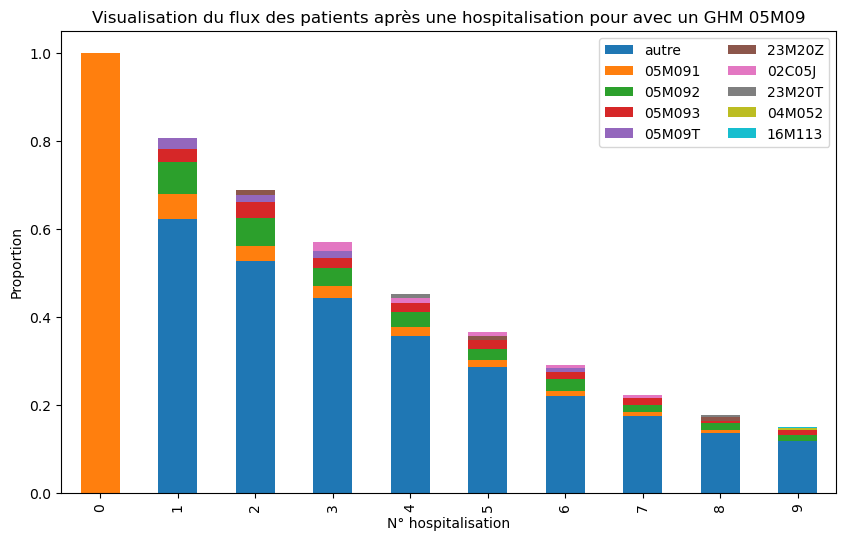

In [407]:
df.plot(kind='bar', stacked=True, colormap='tab10', figsize=(10, 6))
plt.legend(loc="upper right", ncol=2)
plt.xlabel("N° hospitalisation")
plt.ylabel("Proportion")
plt.title('Visualisation du flux des patients après une hospitalisation pour avec un GHM 05M09')
plt.show()

In [ ]:
cross_tab_prop = pd.crosstab(index=df['release_year'],
                             columns=data['type'],
                             normalize="index")
cross_tab_prop

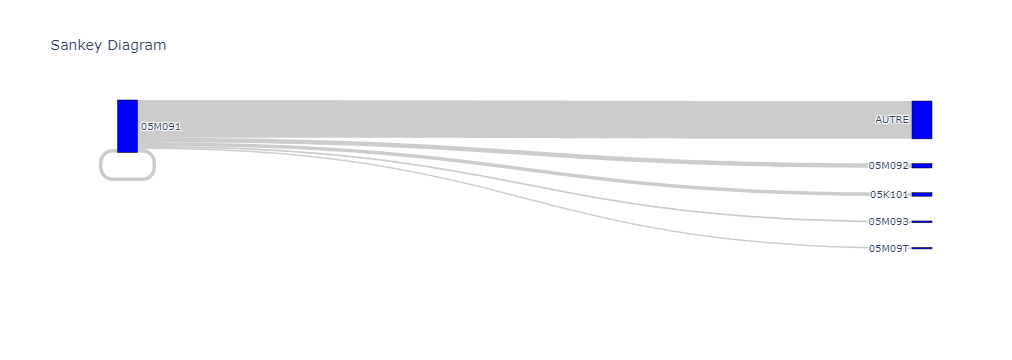

In [187]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ['05M091', '05M092', '05M093', '05M09T', '05K101', '23M20Z', 'AUTRE'],
      color = "blue"
    ),
    link = dict(
      source = [0, 0, 0, 0, 0, 0], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [1, 4, 0, 2, 3, 6],
      value = [7.2527, 5.8242, 5.7143, 2.9670, 2.4176, 62.1978]
  ))])

fig.update_layout(title_text="Sankey Diagram", font_size=10)
fig.show()